In [1]:
import sys, os
sys.path.insert(0, '..')

In [2]:
import residual2vec as rv
import numpy as np
import pandas as pd
from scipy import sparse
import networkx as nx
from torch.utils.data import DataLoader
import torch


import graph_embeddings
from models.crosswalk import Crosswalk
from utils.score import statistical_parity

from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/home/ashutosh/miniconda3/envs/study/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
2022-08-30 10:38:37.354685: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-08-30 10:38:37.379431: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2304000000 Hz
2022-08-30 10:38:37.380236: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560eead22720 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-30 10:38:37.380246: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-30 10:38:37

In [3]:
window_length = 5
num_walks = 10
dim = 128
walk_length = 80
NUM_WORKERS = 4

# POLBOOKS DATASET

In [4]:
DATA_FILE = '../data/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')

nodes = G.nodes(data=True)
labels, group_ids = np.unique([n[1]['value'] for n in nodes], return_inverse=True)

A = nx.adjacency_matrix(G).asfptype()
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)
models, embs = {}, {}

In [5]:
from residual2vec.word2vec import Word2Vec
k = "degree-unbiased"
model = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    walk_length=walk_length
).fit(A)

adjusted_num_walks = np.ceil(
        num_walks
        * np.maximum(
            1,
            model.batch_size
            * model.miniters
            / (model.n_nodes * num_walks * walk_length),
        )
    ).astype(int)
d = rv.TripletSimpleDataset(
        adjmat=model.adjmat,
        group_ids=group_ids,
        num_walks=adjusted_num_walks,
        window_length=model.window_length,
        noise_sampler=model.sampler,
        padding_id=model.n_nodes,
        walk_length=model.walk_length,
        p=model.p,
        q=model.q,
        buffer_size=model.buffer_size,
        context_window_type=model.context_window_type,
    )
dataloader = DataLoader(
        d,
        batch_size=model.batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
models[k] = model
m = Word2Vec(vocab_size=A.shape[0] + 1, embedding_size=dim, padding_idx=A.shape[0])
embs[k] = models[k].transform(model=m, dataloader=dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 506.00it/s, loss=1.15]


In [6]:
k = "group-unbiased"
model = rv.residual2vec_sgd(
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length,
    ),
    window_length=window_length,
    num_walks=num_walks,
    walk_length=walk_length,
).fit(A)
adjusted_num_walks = np.ceil(
        num_walks
        * np.maximum(
            1,
            model.batch_size
            * model.miniters
            / (model.n_nodes * num_walks * walk_length),
        )
    ).astype(int)
d = rv.TripletSimpleDataset(
        adjmat=model.adjmat,
        group_ids=group_ids,
        num_walks=adjusted_num_walks,
        window_length=model.window_length,
        noise_sampler=model.sampler,
        padding_id=model.n_nodes,
        walk_length=model.walk_length,
        p=model.p,
        q=model.q,
        buffer_size=model.buffer_size,
        context_window_type=model.context_window_type,
    )
dataloader = DataLoader(
        d,
        batch_size=model.batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
models[k] = model
m = Word2Vec(vocab_size=A.shape[0] + 1, embedding_size=dim, padding_idx=A.shape[0])
embs[k] = models[k].transform(model=m, dataloader=dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 512.29it/s, loss=1.2]


In [7]:

# from utils.link_prediction import *
# from dataset import triplet_dataset
# from utils.config import *
# k = "degree-unbiased-small-gat"
# model = rv.residual2vec_sgd(
#     noise_sampler=rv.ConfigModelNodeSampler(),
#     window_length=window_length,
#     num_walks=num_walks,
#     walk_length=walk_length
# ).fit(A)
# d = rv.TripletSimpleDataset(
#         adjmat=model.adjmat,
#         group_ids=group_ids,
#         num_walks=adjusted_num_walks,
#         window_length=model.window_length,
#         noise_sampler=model.sampler,
#         padding_id=model.n_nodes,
#         walk_length=model.walk_length,
#         p=model.p,
#         q=model.q,
#         buffer_size=model.buffer_size,
#         context_window_type=model.context_window_type,
#     )
# # d = triplet_dataset.TripletPokecDataset()
# dataloader = triplet_dataset.NeighborEdgeSampler(d, batch_size=model.batch_size, shuffle=True, num_workers=NUM_WORKERS, edge_sample_size=3)
# models[k] = model
# # m = GATLinkPrediction(in_channels=d.num_features, embedding_size=128, num_heads=5, num_layers=3, hidden_channels=64, num_embeddings=d.num_embeddings)
# m = GCNLinkPrediction(in_channels=d.num_features, embedding_size=128, hidden_channels=64, num_layers=5, num_embeddings=d.num_embeddings)
# models[k].transform(model=m, dataloader=dataloader)


# # creating embeddings here, probably need to get approved
# m.to(DEVICE)
# m.eval()
# d = rv.TripletSimpleDataset(
#         adjmat=model.adjmat,
#         group_ids=group_ids,
#         num_walks=1,
#         window_length=1,
#         noise_sampler=model.sampler,
#         padding_id=model.n_nodes,
#         walk_length=1,
#         p=model.p,
#         q=model.q,
#         buffer_size=model.buffer_size,
#         context_window_type=model.context_window_type,debug=True
#     )
# dataloader = triplet_dataset.NeighborEdgeSampler(d, batch_size=1, shuffle=False, 
#                                                  num_workers=1, edge_sample_size=3, transforming=True)
# emb = np.empty((len(group_ids), 128))
# for idx, batch in enumerate(tqdm(dataloader)):
#     with torch.no_grad():
# #         print(idx)
#         # emb[idx, :]= m.forward_i(batch[0]).detach().cpu().numpy()
#         emb[idx * 1: (idx + 1) * 1, :] = m.forward_i(batch[0]).detach().cpu().numpy()
# embs[k] = emb.copy()


In [8]:
embs["fairwalk"] = graph_embeddings.Fairwalk(window_length=window_length, num_walks=num_walks).fit(A).transform(dim=dim)
embs["fairwalk-group"] = graph_embeddings.Fairwalk(
    window_length=window_length, num_walks=num_walks, group_membership=group_ids
).fit(A).transform(dim=dim)
embs['GCN'] = graph_embeddings.GCN().fit(A).transform(dim=dim)
embs["gcn-doubleK"] = graph_embeddings.GCN(num_default_features=dim * 2).fit(A).transform(dim=dim)
embs["graphsage"] = graph_embeddings.GraphSage().fit(A).transform(dim=dim)
embs["graphsage-doubleK"] = graph_embeddings.GraphSage(num_default_features=dim * 2).fit(A).transform(dim=dim)
embs["gat"] = graph_embeddings.GAT(layer_sizes=[64, 256]).fit(A).transform(dim=dim)
embs["gat-doubleK"] = graph_embeddings.GAT(num_default_features=dim * 2).fit(A).transform(dim=dim)

embs['crosswalk'] = Crosswalk(group_membership=group_ids, window_length=window_length, num_walks=num_walks).fit(A).transform(dim=dim)

Using GCN (local pooling) filters...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VE

Epoch 51/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0070 - val_loss: 0.0114
Epoch 52/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0070 - val_loss: 0.0114
Epoch 53/200
1/1 [==============================] - 0s 58ms/step - loss: 0.0071 - val_loss: 0.0114
Epoch 54/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0068 - val_loss: 0.0115
Epoch 55/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0068 - val_loss: 0.0116
Epoch 56/200
1/1 [==============================] - 0s 68ms/step - loss: 0.0067 - val_loss: 0.0118
Epoch 57/200
1/1 [==============================] - 0s 62ms/step - loss: 0.0068 - val_loss: 0.0119
Epoch 58/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0068 - val_loss: 0.0120
Epoch 59/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0064 - val_loss: 0.0121
Epoch 60/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0065 - val_loss: 0.0121
Epoch 61/2

  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/200
1/1 [==============================] - 1s 717ms/step - loss: 0.0098 - val_loss: 0.0099
Epoch 2/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0095 - val_loss: 0.0099
Epoch 3/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0094 - val_loss: 0.0099
Epoch 4/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 5/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 6/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 7/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 8/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0091 - val_loss: 0.0098
Epoch 9/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 10/200
1/1 [==============================] - 

Epoch 83/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0060 - val_loss: 0.0128
Epoch 84/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0063 - val_loss: 0.0128
Epoch 85/200
1/1 [==============================] - 0s 61ms/step - loss: 0.0061 - val_loss: 0.0129
Epoch 86/200
1/1 [==============================] - 0s 58ms/step - loss: 0.0061 - val_loss: 0.0130
Epoch 87/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0062 - val_loss: 0.0132
Epoch 88/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0062 - val_loss: 0.0130
Epoch 89/200
1/1 [==============================] - 0s 38ms/step - loss: 0.0059 - val_loss: 0.0128
Epoch 90/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0061 - val_loss: 0.0128
Epoch 91/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0059 - val_loss: 0.0129
Epoch 92/200
1/1 [==============================] - 0s 38ms/step - loss: 0.0059 - val_loss: 0.0131
Epoch 93/2

2022-08-30 10:39:00.115739: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 565ms/step - loss: 0.6954 - binary_accuracy: 0.5000
Epoch 3/5


2022-08-30 10:39:00.744470: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 682ms/step - loss: 0.6647 - binary_accuracy: 0.5286
Epoch 4/5


2022-08-30 10:39:01.385826: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 654ms/step - loss: 0.6417 - binary_accuracy: 0.6524
Epoch 5/5


2022-08-30 10:39:02.040093: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 598ms/step - loss: 0.6281 - binary_accuracy: 0.6905


2022-08-30 10:39:02.677841: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 182ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `exp

2022-08-30 10:39:03.235100: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

2022-08-30 10:39:05.087950: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 563ms/step - loss: 0.7126 - binary_accuracy: 0.5000
Epoch 3/5


2022-08-30 10:39:05.747926: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 668ms/step - loss: 0.6760 - binary_accuracy: 0.5095
Epoch 4/5


2022-08-30 10:39:06.368158: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 691ms/step - loss: 0.6540 - binary_accuracy: 0.6000
Epoch 5/5


2022-08-30 10:39:07.031690: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 651ms/step - loss: 0.6204 - binary_accuracy: 0.7048


2022-08-30 10:39:07.696374: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 247ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


2022-08-30 10:39:08.254921: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

Epoch 62/200
1/1 [==============================] - 0s 60ms/step - loss: 0.0088 - val_loss: 0.0098
Epoch 63/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0088 - val_loss: 0.0098
Epoch 64/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 65/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 66/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 67/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0089 - val_loss: 0.0099
Epoch 68/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 69/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 70/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 71/200
1/1 [==============================] - 0s 63ms/step - loss: 0.0089 - val_loss: 0.0099
Epoch 72/2

Epoch 2/200
1/1 [==============================] - 0s 89ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 3/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0094 - val_loss: 0.0099
Epoch 4/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 5/200
1/1 [==============================] - 0s 86ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 6/200
1/1 [==============================] - 0s 92ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 7/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 8/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 9/200
1/1 [==============================] - 0s 177ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 10/200
1/1 [==============================] - 0s 111ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 11/200
1/1 [==============================] - 0s 90ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 12/200
1/1

Epoch 85/200
1/1 [==============================] - 0s 105ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 86/200
1/1 [==============================] - 0s 86ms/step - loss: 0.0093 - val_loss: 0.0101
Epoch 87/200
1/1 [==============================] - 0s 94ms/step - loss: 0.0087 - val_loss: 0.0102
Epoch 88/200
1/1 [==============================] - 0s 90ms/step - loss: 0.0087 - val_loss: 0.0102
Epoch 89/200
1/1 [==============================] - 0s 89ms/step - loss: 0.0092 - val_loss: 0.0102
Epoch 90/200
1/1 [==============================] - 0s 102ms/step - loss: 0.0093 - val_loss: 0.0100
Epoch 91/200
1/1 [==============================] - 0s 100ms/step - loss: 0.0092 - val_loss: 0.0100
Epoch 92/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0091 - val_loss: 0.0101
Epoch 93/200
1/1 [==============================] - 0s 117ms/step - loss: 0.0085 - val_loss: 0.0101
Epoch 94/200
1/1 [==============================] - 0s 134ms/step - loss: 0.0091 - val_loss: 0.0101
Epoch

In [9]:
# K = "degree_unbiased_gcn_pokec"

# import pickle as pkl

# embs[K] = pkl.load(open("emb_{}.pkl".format("degree-unbiased-gcn"), "rb"))["degree-unbiased-gcn"]

In [10]:
for k, v in embs.items():
    print(k, v.shape)

degree-unbiased (105, 128)
group-unbiased (105, 128)
fairwalk (105, 128)
fairwalk-group (105, 128)
GCN (105, 128)
gcn-doubleK (105, 128)
graphsage (105, 128)
graphsage-doubleK (105, 128)
gat (105, 128)
gat-doubleK (105, 128)
crosswalk (70, 128)
degree_unbiased_gcn_pokec (1632803, 128)


In [11]:
def reconstruct_graph(emb, n, m):
    # choose top m edges to reconstruct the graph
    S = emb @ emb.T
    S = np.triu(S, k=1)
    r, c, v = sparse.find(S)
    idx = np.argsort(-v)[:m]
    r, c, v = r[idx], c[idx], v[idx]
    B = sparse.csr_matrix((v, (r, c)), shape=(n, n))
    B = B + B.T
    B.data = B.data * 0 + 1
    return nx.from_scipy_sparse_matrix(B + B.T)

In [12]:

rgraphs = {}
for k, emb in embs.items():
#     if k == K:
#         n_edges = 30622564 // 2
#         n_nodes = emb.shape[0]
#         continue
#     else:
    n_edges = int(A.sum() / 2)
    n_nodes = A.shape[0]
    rgraphs[k] = reconstruct_graph(emb, n_nodes, n_edges)

In [13]:
scores = {}
for k, graph in rgraphs.items():
    # we will have to change group ids as well.
    scores[k] = statistical_parity(graph, group_ids)
    print("class score: ", k, scores[k])

class score:  degree-unbiased 0.16500354805431186
class score:  group-unbiased 0.1096486032819944
class score:  fairwalk 0.16511268424772294
class score:  fairwalk-group 0.15359607604679335
class score:  GCN 0.13983189530839035
class score:  gcn-doubleK 0.1564731310244656
class score:  graphsage 0.07166510992924376
class score:  graphsage-doubleK 0.09221156182661439
class score:  gat 0.14853003892672803
class score:  gat-doubleK 0.19949795150658767
class score:  crosswalk 0.08417923600464998


[Text(0,0,'degree-unbiased'),
 Text(0,0,'group-unbiased'),
 Text(0,0,'fairwalk'),
 Text(0,0,'fairwalk-group'),
 Text(0,0,'GCN'),
 Text(0,0,'gcn-doubleK'),
 Text(0,0,'graphsage'),
 Text(0,0,'graphsage-doubleK'),
 Text(0,0,'gat'),
 Text(0,0,'gat-doubleK'),
 Text(0,0,'crosswalk')]

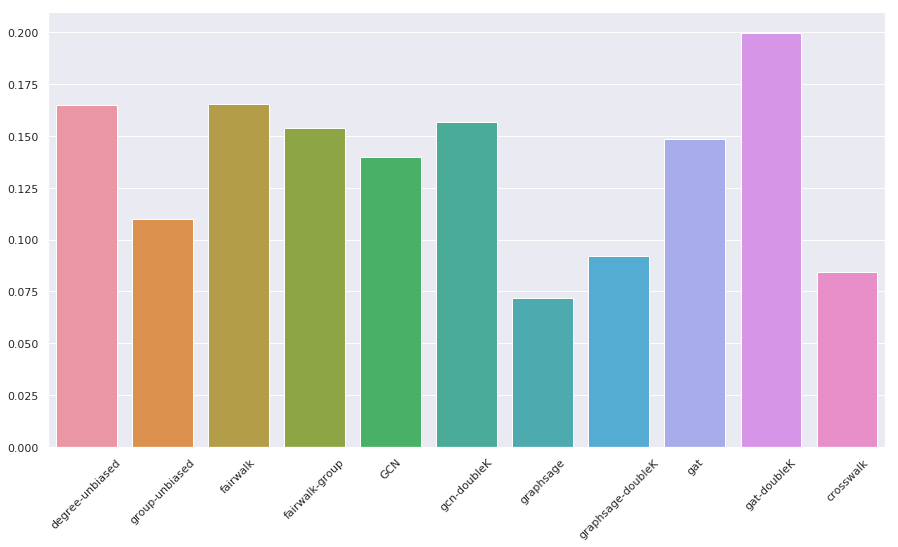

In [14]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)